## Do Imports

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import math
import pprint
from __future__ import division
from __future__ import print_function
from datetime import datetime
import matplotlib.pyplot as plt
import os
from fractions import Fraction 
import scipy.odr.odrpack as odrpack
import time
from bisect import bisect_left
import datetime as dt
import matplotlib.dates as mdates
import calendar

## Define functions for dataSet computation

In [2]:
def avageAndStdDeviationOverSeconds(dataPoints, currentIndex, collumToAnalyze, averagingSeconds):
    '''
    Returns a tupel, with outTupel[0] the average and outTupel[1] the standard deviation.
    Calculates the average and standard deviation over a given time.
    Starting from the data point at currentIndex in dataPoints and going back the number of averagingSeconds.
    It is assumed, that dataPonts is a Pandas DataFrame, with timestamps as indexes
    and that it is sortet, so that the latest/newest entry is at the beginning of the DataFrame.
    '''
    timestamps = dataPoints.axes[0]
    data = dataPoints.values
    outTupel = [0, 0]
    secondsAgo = timestamps[currentIndex] - averagingSeconds
    if ( timestamps[len(timestamps)-1] > secondsAgo):
        secondsAgo = timestamps[len(timestamps)-1]
    # cut array
    lastIndex = 0
    for i in xrange(currentIndex, len(data)):
        if timestamps[i] <= secondsAgo :
            lastIndex = i
            break
    cutData = np.split(dataPoints, [currentIndex, lastIndex + 1])[1]
    data = cutData.values
    columNames = cutData.axes[1]
    # calculate average and variance
    avg = cutData[columNames[collumToAnalyze]].mean()
    outTupel[0] = avg
    std = cutData[columNames[collumToAnalyze]].std()
    outTupel[1] = std
    return outTupel

def nextMeasurementAndDistance(dataPoints, currentIndex, collumToAnalyze, numberOfMeasurementsToSkip=0):
    '''
    Returns a tuple with outTupel[0] the next measurement in time and outTupel[1]
    the distance of the next measurement to the timestamp at currentIndex, devided by averagingSeconds
    TODO: evaluate, how usefull it is to devide by averagingSeconds [edit: just removed it because it seemed useless]
    '''
    countNum = numberOfMeasurementsToSkip
    timestamps = dataPoints.axes[0]
    data = dataPoints.values
    outTupel = [0, 0]
    nextIndex = currentIndex + 1
    while True:
        if nextIndex >= len(timestamps):
            nextIndex = currentIndex
            break
        if math.isnan(data[nextIndex][collumToAnalyze]) == False:
            if countNum == 0:
                break
            else:
                countNum -= 1
        nextIndex = nextIndex + 1
    outTupel[0] = data[nextIndex][collumToAnalyze]
    outTupel[1] = (timestamps[currentIndex] - timestamps[nextIndex])
    return outTupel


def findIndexClostestThatIsNotNAN(startIndex, dataPoints, collumThatIsNotNAN):
    '''
    Returns an index for dataPoints, that is:
    a) in the collum "collumThatIsNotNAN" not nan.
    b) closest to startIndex (looking fowards and backwards at the same time in the array).
       This "proximity" does not take the timestamp into account, just the numerical
       distance from startIndex to the returned index.
    If no occurence is found it will raise an error, but this case should be ultra rare.
    ATENTION: This function may look into the "future" of the data set which may not be possible in the future.
    '''
    hitBeginningOfList = False
    hitEndOfList = False
    index1 = startIndex
    index2 = startIndex
    while (hitEndOfList==False) or (hitBeginningOfList==False):
        index1 += 1
        index2 -= 1
        if (hitEndOfList == True) or (index1 == len(dataPoints)):
            hitEndOfList = True
        else:
            currentDataPoint = dataPoints.values[index1]
            if not math.isnan(currentDataPoint[collumThatIsNotNAN]):
                return index1
        if (hitBeginningOfList == True) or (index2 == -1):
            hitBeginningOfList = True
        else:
            currentDataPoint = dataPoints.values[index2]
            if not math.isnan(currentDataPoint[collumThatIsNotNAN]):
                return index2
    raise StandardError("Could not find a closest occurence, does the data even contain values in that colum?")


def findDataPointClosestToTimestamp(timestamp, dataPoints, collumThatIsNotNAN):
    '''
    Returns a data point from dataPoints, that is closest to the given timestamp.
    As well the dataPoint will not be nan in the collum "collumThatIsNotNAN"
    Complexity of this command: O( log( len(dataPoints) ) )
    '''
    timestamps_toSearch = dataPoints.axes[0]
    data = dataPoints.values
    # bisect only works because we know our list is sorted
    pos = bisect_left(timestamps_toSearch, timestamp)
    if pos == len(dataPoints):
        pos = len(dataPoints)-1
    # find the closest datapoint, that is not a NAN and return it
    currentDataPoint = dataPoints.values[pos]
    if not math.isnan(currentDataPoint[collumThatIsNotNAN]):
        return currentDataPoint
    else:
        pos = findIndexClostestThatIsNotNAN(pos, dataPoints, collumThatIsNotNAN)
        currentDataPoint = dataPoints.values[pos]
        return currentDataPoint
    



def createDataSets(dataPoints_forth, dataPoints_back, averagingSeconds_Throughput, averagingSeconds_Delay_and_Loss):
    '''
    Returns a data sets (in form of a pandas DataFrame), derived from the given dataPoints_forth,
    and small parts of dataPoints_back.
    A data set contains information about throughput, packetloss and delay for a given point in time.
    '''
    timestamps = dataPoints_forth.axes[0]
    data = dataPoints_forth.values
    dataSetList = []
    # go through the data
    print("Current percentage of analyzed dataPoints: ")
    for i in xrange(len(dataPoints_forth)):
        # find a point, where we have throughput data
        if math.isnan(data[i][5]) == False:
            currentSet = {}
            # get all the throughput data:
            currentSet["timestamp"] = timestamps[i]
            currentSet["throughput_perfSonar"] = data[i][5]
            # take out this part at the moment as the network converges to fast
            '''avgAStdThroughput = avageAndStdDeviationOverSeconds(dataPoints_forth, i, 5, averagingSeconds_Throughput)
            currentSet["throughput_average"] = avgAStdThroughput[0]
            currentSet["throughput_std_deviation"] = avgAStdThroughput[1]
            nextAndDist = nextMeasurementAndDistance(dataPoints_forth, i, 5)
            currentSet["throughput_last_measurement"] = nextAndDist[0]
            currentSet["throughput_last_measurement_time"] = nextAndDist[1]'''
            
            # get closest throughput data from the routers
            nextValidIndex = findIndexClostestThatIsNotNAN(i, dataPoints_forth, 6)
            currentSet["throughput_router"] = data[nextValidIndex][6]
            
            # get all packetloss data:
            # TODO: replace this with a search in both directions
            nextValidIndex = findIndexClostestThatIsNotNAN(i, dataPoints_forth, 4)
            currentSet["packet_loss"] = data[nextValidIndex][4]
            avgAStdPacket_loss = avageAndStdDeviationOverSeconds(dataPoints_forth, nextValidIndex, 4, averagingSeconds_Delay_and_Loss)
            currentSet["packet_loss_average"] = avgAStdPacket_loss[0]
            currentSet["packet_loss_std_deviation"] = avgAStdPacket_loss[1]
            
            # get all delay data
            nextValidIndex = findIndexClostestThatIsNotNAN(i, dataPoints_forth, 2)
            fittingDataPoint_back = findDataPointClosestToTimestamp(currentSet["timestamp"], dataPoints_back, 2)
            currentSet["delay_current_average_forth"] = data[nextValidIndex][2]
            currentSet["delay_current_average_back"] = fittingDataPoint_back[2]
            currentSet["delay_current_std_deviation_forth"] = data[nextValidIndex][3]
            currentSet["delay_current_std_deviation_back"] = fittingDataPoint_back[3]
            avgAStdPacket_loss = avageAndStdDeviationOverSeconds(dataPoints_forth, nextValidIndex, 1, averagingSeconds_Delay_and_Loss)
            currentSet["delay_timed_average"] = avgAStdPacket_loss[0]
            currentSet["delay_timed_std_deviation"] = avgAStdPacket_loss[1]
            
            dataSetList.append(currentSet)
        if (i % 1000) == 0:
            print(str(100*i/len(dataPoints_forth)) +" %, " , end="")
    print(" ")
    print("Total created data sets: " + str(len(dataSetList)))
    dataFrame = pd.DataFrame.from_dict(dataSetList)
    return dataFrame


def createDatasetsFromFilesInFolder(path, averagingSeconds):
    '''
    This function is outdated at the moment and will crash!
    '''
    count = 0
    outputDataSets = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        # read all files
        for filename in filenames:
            print("----------------------- reading file: " + filename)
            dataPoints = pd.read_pickle(str(path + filename))
            # make sure it is sorted
            dataPoints.sort_index(inplace=True, ascending=False)
            dataSets = createDataSets(dataPoints, averagingSeconds)
            outputDataSets.append(dataSets)
            count =  count + 1
            print(" ")
    print("Number of read files: " + str(count))
    print(" ")
    return outputDataSets


In [3]:
def getDataSetWithPacketloss(dataSet):
    dataSetsWithPacketloss = dataSet.copy(deep=True)
    count = 0
    while count < len(dataSetsWithPacketloss):
        loss = dataSetsWithPacketloss['packet_loss'][count]
        # remove unwanted data:
        if loss < 0.0 and loss > 0.05:
            dataSetsWithPacketloss = dataSetsWithPacketloss.drop(count, axis=0)
            # no need to set the counter higher, since we removed a line
        else:
            # keep this line and conut one up
            count += 1
    print( "Number of dataSets with packet_loss: " + str(len(dataSetsWithPacketloss)))
    return dataSetsWithPacketloss

## Define functions for the analytical model

In [4]:
def calcMathisModel_outMBitsPerSec(packetloss, MSS, RTT, C=np.sqrt(3/2)):
    '''
    Returns the result of mathis model in Bits/s.
    It does work with np.arrays.
    '''
    outVal = (MSS/RTT)*C/np.sqrt(packetloss)
    # convert inf vals to nan
    outVal = outVal*np.isfinite(outVal)
    return outVal


In [5]:
# smir out data
def smirDataFrame(data, steps):
    # make sure that there are no nans! This would brick the cumsum function!
    # This may happen naturally when the packet_loss is at 1, so no packets get through
    # for simplicity we will drop those lines    
    data_smired = data.copy(deep=True)
    if "packet_loss" in data_smired.axes[1]:
        data_smired = data_smired.dropna(axis=0)
    for col in data_smired.axes[1]:
        vals = data_smired[col].values
        valsSumed = np.cumsum(vals)
        for i in xrange(steps, len(data_smired)):
            summ = valsSumed[i] - valsSumed[i-steps]
            vals[i] = summ/steps
        vals[:steps] = float('nan')
        data_smired[col] = vals
    return data_smired

## Import raw data and compute dataset

In [142]:
# read our raw data
data_router = pd.read_pickle("raw_data_routers/raw_router_CERN_to_RAL-PIC-TRIUMF-KIT-IN2P3-BNL-CNAF_highres.pkl")
data_perfSonar = pd.read_pickle("raw_data_routers/raw_toolkit_CERN_to_RAL-PIC-TRIUMF-KIT-IN2P3-BNL-CNAF_sorted.pkl")


data_router.axes[1]
#data_perfSonar['KIT']['out'].axes[1]

Index([u'throughput_ES-PIC_router_1_in', u'throughput_ES-PIC_router_1_out',
       u'throughput_UK-RAL_router_1_in', u'throughput_UK-RAL_router_1_out',
       u'throughput_UK-RAL_router_2_in', u'throughput_UK-RAL_router_2_out',
       u'throughput_CA-TRIUMF_router_1_in',
       u'throughput_CA-TRIUMF_router_1_out', u'throughput_DE-KIT_router_1_in',
       u'throughput_DE-KIT_router_1_out', u'throughput_DE-KIT_router_2_in',
       u'throughput_DE-KIT_router_2_out', u'throughput_FR-CCIN2P3_router_1_in',
       u'throughput_FR-CCIN2P3_router_1_out',
       u'throughput_FR-CCIN2P3_router_2_in',
       u'throughput_FR-CCIN2P3_router_2_out',
       u'throughput_US-T1-BNL_router_1_in',
       u'throughput_US-T1-BNL_router_1_out',
       u'throughput_US-T1-BNL_router_2_in',
       u'throughput_US-T1-BNL_router_2_out',
       u'throughput_US-T1-BNL_router_3_in',
       u'throughput_US-T1-BNL_router_3_out',
       u'throughput_IT-INFN-CNAF_router_1_in',
       u'throughput_IT-INFN-CNAF_router_1_

In [143]:
# data processing
# smir data
steps = 8
data_router = smirDataFrame(data_router, steps)
steps = 40
for key in data_perfSonar.keys():
    for key2 in data_perfSonar[key]:
        # smir the data
        data_perfSonar[key][key2] = smirDataFrame(data_perfSonar[key][key2], steps)
        # add the gradient for delay_avg and packetloss
        data_perfSonar[key][key2]['delay_avg_gradient'] = np.gradient(data_perfSonar[key][key2]['delay_avg'], edge_order=2)
        data_perfSonar[key][key2]['packet_loss_gradient'] = np.gradient(data_perfSonar[key][key2]['packet_loss'], edge_order=2)
       

# make dates for the plots
dates_router = []
for stamp in data_router.index:
    dates_router.append(dt.datetime.fromtimestamp(stamp))
    
dates_perfSonar = {}
for dest in data_perfSonar:
    dates_perfSonar[dest] = {}
    for direction in data_perfSonar[dest]:
        dates_perfSonar[dest][direction] = []
        for stamp in data_perfSonar[dest][direction].index:
            dates_perfSonar[dest][direction].append(dt.datetime.fromtimestamp(stamp))

## Scatter plotting

In [8]:
def findDataPointClosestToTimestamp_mod(timestamp, dataPoints, collumThatIsNotNAN):
    '''
    Returns a data point from dataPoints, that is closest to the given timestamp.
    As well the dataPoint will not be nan in the collum "collumThatIsNotNAN"
    Complexity of this command: O( log( len(dataPoints) ) )
    '''
    timestamps_toSearch = dataPoints.axes[0]
    cols = list(dataPoints.axes[1])
    data = dataPoints.values
    # bisect only works because we know our list is sorted
    pos = bisect_left(timestamps_toSearch, timestamp)
    if pos == len(dataPoints):
        pos = len(dataPoints)-1
    #print(pos)
    # find the closest datapoint, that is not a NAN and return it
    currentDataPoint = dict(zip(cols, dataPoints.values[pos]))
    if not math.isnan(currentDataPoint[collumThatIsNotNAN]):
        return currentDataPoint
    else:
        pos = findIndexClostestThatIsNotNAN(pos, dataPoints, cols.index(collumThatIsNotNAN))
        currentDataPoint = dict(zip(cols, dataPoints.values[pos]))
        return currentDataPoint

def makeNewDataSet(data_from_routers, data_from_perfSonar, timeframe):
    # cut routers data
    pos1 = bisect_left(data_from_routers.index, timeframe[0])
    if pos1 == len(data_from_routers):
        pos1 = len(data_from_routers)-1
    pos2 = bisect_left(data_from_routers.index, timeframe[1])
    if pos2 == len(data_from_routers):
        pos2 = len(data_from_routers)-1
    data_from_routers = data_from_routers.drop(data_from_routers.index[0:pos1])
    data_from_routers = data_from_routers.drop(data_from_routers.index[pos2:len(data_from_routers)-1])
    data = []
    for i in xrange(len(data_from_routers)):
        currentTimestamp = data_from_routers.index[i]
        #print(currentTimestamp)
        zw = findDataPointClosestToTimestamp_mod(currentTimestamp, data_from_perfSonar, 'delay_avg')
        zw['timestamp'] = currentTimestamp
        zw['throughput'] = data_from_routers.values[i]
        data.append(zw)
    data = pd.DataFrame.from_dict(data)
    return data

def filter_low_throughput(throughputMaxGBits, throughputPercentage, data_set):
    data_set_out = data_set.copy(deep=True)
    counter = 0
    while counter < len(data_set_out):
        if data_set_out.iloc[counter]['throughput'] < (throughputMaxGBits*1e9*throughputPercentage):
            data_set_out = data_set_out.drop(data_set_out.index[counter])
        else:
            counter += 1
    return data_set_out

def filter_nonVaring_latency(data_set, min_var_in_std=0.25):
    data_set_out = data_set.copy(deep=True)
    std = data_set_out['delay_avg'].std()*min_var_in_std
    # the median will give us something which is closer to the baseline,
    # since it less sensitive to short, big spikes
    median = data_set_out['delay_avg'].median()
    # drop all rows, which are in the range of half a standard deviation
    counter = 0
    while counter < len(data_set_out):
        if data_set_out.iloc[counter]['delay_avg'] < (median+std):
            data_set_out = data_set_out.drop(data_set_out.index[counter])
        else:
            counter += 1
    return data_set_out

In [179]:
# make Scatter plot
# configuration
src = "CERN"
dest = "PIC"
direction = "out"
further_info='throughput vs latency * log( packet_loss*1e6+1 )'
throughputMaxGBits = 10
throughputPercentage = 0.7
timeframe_readable = ['15-09-2016 06:00', '16-09-2016 00:00']


# setting stuff up
timeframe = [calendar.timegm(dt.datetime.strptime(t, '%d-%m-%Y %H:%M').timetuple()) for t in timeframe_readable]
timeframe = [1473811200, 1474756800]
dirMarker = " <- "
if direction == "out":
    dirMarker = " -> "
title = "Scatter plot "+src+dirMarker+dest +"\n"+further_info+"\nTimeframe: "+str(timeframe_readable[0])+" to "+str(timeframe_readable[1])
fname = title

# make dataSet
throughputs = []
for router in data_router.axes[1]:
    if dest in router and direction in router[len(router)-3:]:
        throughputs.append(data_router[router])
data_from_routers = sum(throughputs).copy(deep=True)
data_from_routers_gradient = np.gradient(data_from_routers, edge_order=2)
data_from_perfSonar = data_perfSonar[dest][direction].copy(deep=True)
# bisect doesn't work if the data is not sortet this way...
data_from_routers = data_from_routers.sort_index(ascending=True)
data_from_perfSonar = data_from_perfSonar.sort_index(ascending=True)
data_set = makeNewDataSet(data_from_routers, data_from_perfSonar, timeframe)
data_set = data_set

# filter data_set

# filter data which is inside the "normal" ausage parameter
# min var should be fitting to the data, if there are only small variances (see TRIUMF),
# then a small value like ~0.2 might be good, for larger variances (see RAL),
# something like ~0.5 might be good.
#data_set = filter_nonVaring_latency(data_set, min_var_in_std=0.2)

# filter low bandwiths
data_set = filter_low_throughput(throughputMaxGBits, throughputPercentage, data_set)
len(data_set)

356

In [180]:
#print(data_set.corr(method='pearson')['throughput'])
print(" ")
#print(data_set.corr(method='spearman')['throughput'])
pearson_delay = data_set.corr(method='pearson')['throughput']['delay_avg']
pearson_loss = data_set.corr(method='pearson')['throughput']['packet_loss']
spearman_delay = data_set.corr(method='spearman')['throughput']['delay_avg']
spearman_loss = data_set.corr(method='spearman')['throughput']['packet_loss']

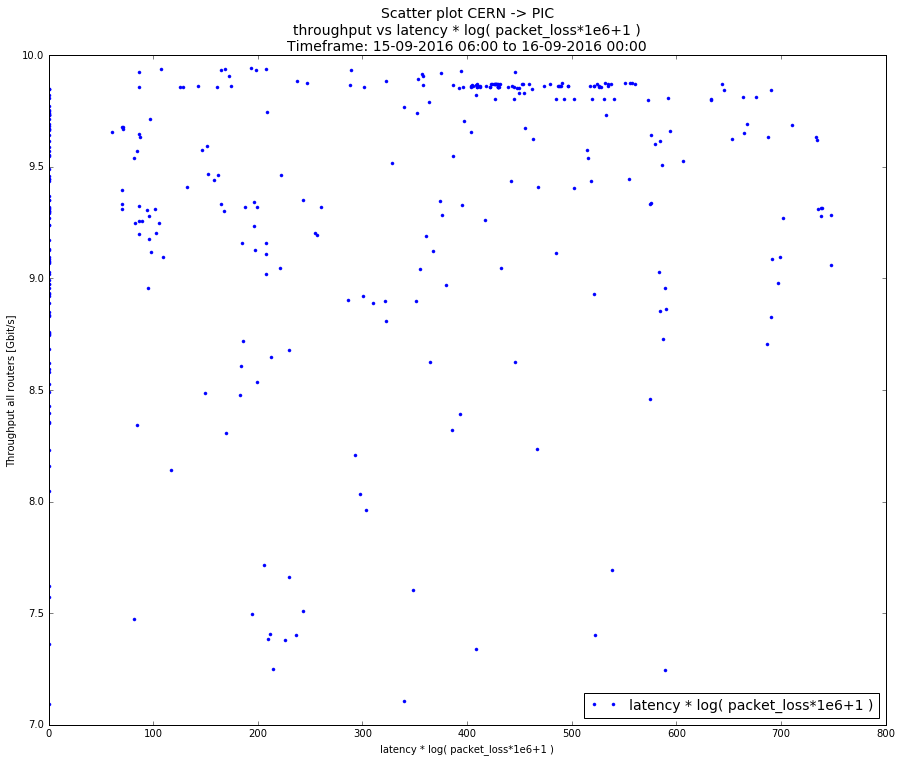

In [192]:
# plot the data we got
fig, ax1 = plt.subplots()
fig.set_size_inches(15,12)
fig.set_dpi(300)
plt.title(title,fontsize=14)

#ax1.plot(data_set['delay_avg']*data_set['packet_loss'], data_set['throughput']/1e9,
#         'r.', label="latency*packet_loss")
#ax1.plot(data_set['delay_avg'], data_set['throughput']/1e9,
#         'b.', label="latency")
ax1.plot(data_set['delay_avg']*np.log(data_set['packet_loss']*1e6+1), data_set['throughput']/1e9,
         'b.', label="latency * log( packet_loss*1e6+1 )")
#ax1.plot(x, data_set['throughput']/1e9,
#         'r.', label="latency")
ax1.set_ylabel("Throughput all routers [Gbit/s]")
ax1.set_xlabel("latency * log( packet_loss*1e6+1 )")

ax1.legend(loc='best',fontsize=14)

#ax1.set_ylim([0, 12])
#plt.xlim(0, 0.15)


#plt.savefig('plots/scatter_plots_2016-09-20/'+ fname +'.png', format='PNG', dpi=300)

plt.show()

## Multi plotting

In [32]:
src = "CERN"
dest = "RAL"
direction = "out"
timeframe = ['15-09-2016 00:00', '19-09-2016 00:00']
direction_counter = "in"
if direction == "in":
    direction_counter = "out"
MSS = 9000
packetloss = data_perfSonar[dest][direction]["packet_loss"]
RTT = np.empty(len(data_perfSonar[dest][direction]))
for i in xrange(len(data_perfSonar[dest][direction])):
    timestamp = data_perfSonar[dest][direction].index[i]
    counter_Data = findDataPointClosestToTimestamp_mod(timestamp, data_perfSonar[dest][direction_counter], "delay_avg")
    RTT[i] = counter_Data["delay_avg"] + data_perfSonar[dest][direction].iloc[i]["delay_avg"]
RTT

array([         nan,          nan,          nan, ...,  26.99588909,
        25.49314326,  24.77761409])

In [9]:
def makePlot(src, dest, direction, timeframe, data_perfSonar, dates_perfSonar, data_router, dates_router, savePath=''):
    # set stuff up
    direction_counter = "in"
    if direction == "in":
        direction_counter = "out"
    dirMarker = " <- "
    if direction == "out":
        dirMarker = " -> "
    title = "Multi plot for "+src+" and "+dest +"\nDirection: "+dirMarker+"\nTimeframe: "+str(timeframe[0])+" to "+str(timeframe[1])
    fname = title
    # plot the data we got
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18,12)
    fig.set_dpi(300)
    plt.title(title,fontsize=14)

    # make first axis
    ax1.plot(dates_perfSonar[dest][direction], data_perfSonar[dest][direction]["delay_avg"]/10,
             'y', label=r'Delay avg /10')
    ax1.plot(dates_perfSonar[dest][direction_counter], data_perfSonar[dest][direction_counter]["delay_avg"]/10,
             'c', label=r'Delay counter avg /10')
    # get throughput
    throughputs = []
    for router in data_router.axes[1]:
        if dest in router and direction in router[len(router)-3:]:
            throughputs.append(data_router[router])
    combinded_throughput = sum(throughputs)
    ax1.plot(dates_router, combinded_throughput/1e9,
             'b', label=r'Throughput all ('+str(len(throughputs))+') routers')
    # plot mathis
    
    
    # make second axis
    ax2 = ax1.twinx()
    ax2.plot(dates_perfSonar[dest][direction], data_perfSonar[dest][direction]["packet_loss"],
             'g', label=r'Packetloss')

    # limits
    #ax1.set_ylim([0, 20])
    ax2.set_ylim([0, 0.05])
    plt.xlim([dt.datetime.strptime(t, '%d-%m-%Y %H:%M') for t in timeframe])
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M'))
    plt.gcf().autofmt_xdate()
    # legends and lables
    ax1.set_ylabel("Throughput [Gbit/s] and Latency [ms/10]")
    ax1.set_xlabel("Time [s since epoch]")
    ax1.legend(loc='upper left',fontsize=14)
    ax2.set_ylabel("Packetloss")
    ax2.legend(loc='upper right',fontsize=14)
    # saving?
    if savePath != '' :
        plt.savefig(savePath+ fname +'.png', format='PNG', dpi=200, bbox_inches='tight', pad_inches=0.7)
    plt.show()

def makeAllPlots(timeframe, savePath = ''):
    for dest in data_perfSonar.keys():
        direction = "out"
        makePlot(src, dest, direction, timeframe, data_perfSonar, dates_perfSonar, data_router, dates_router, savePath=savePath)
        direction = "in"
        makePlot(src, dest, direction, timeframe, data_perfSonar, dates_perfSonar, data_router, dates_router, savePath=savePath)


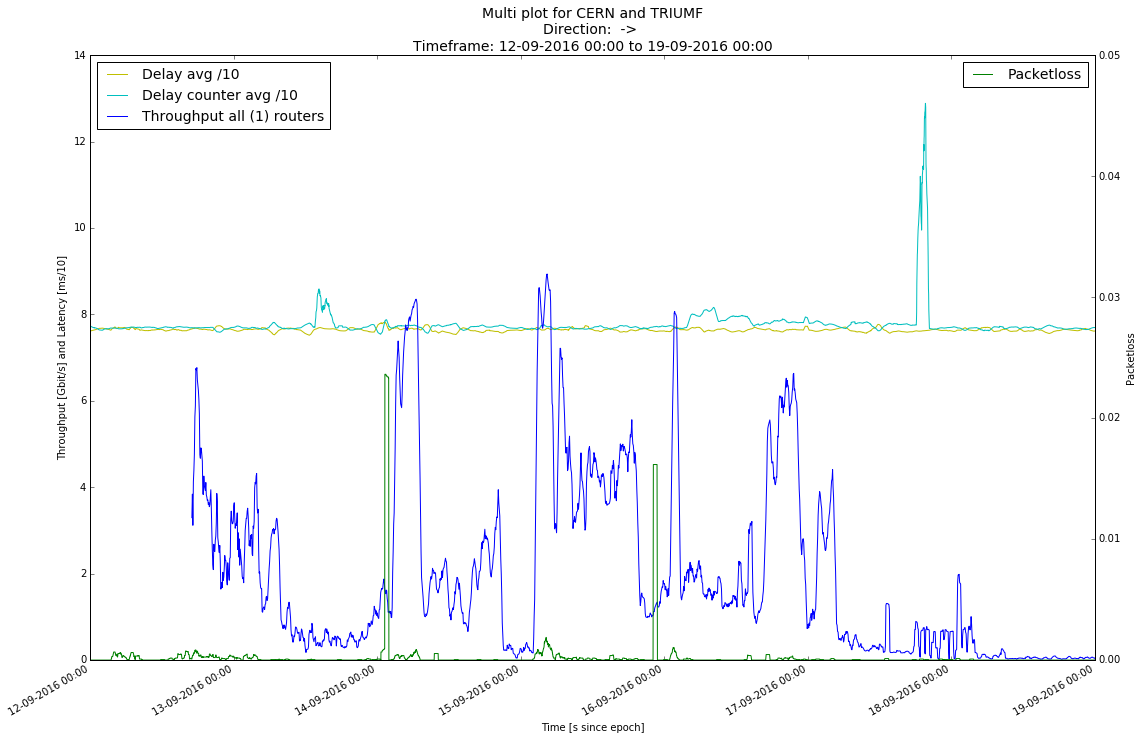

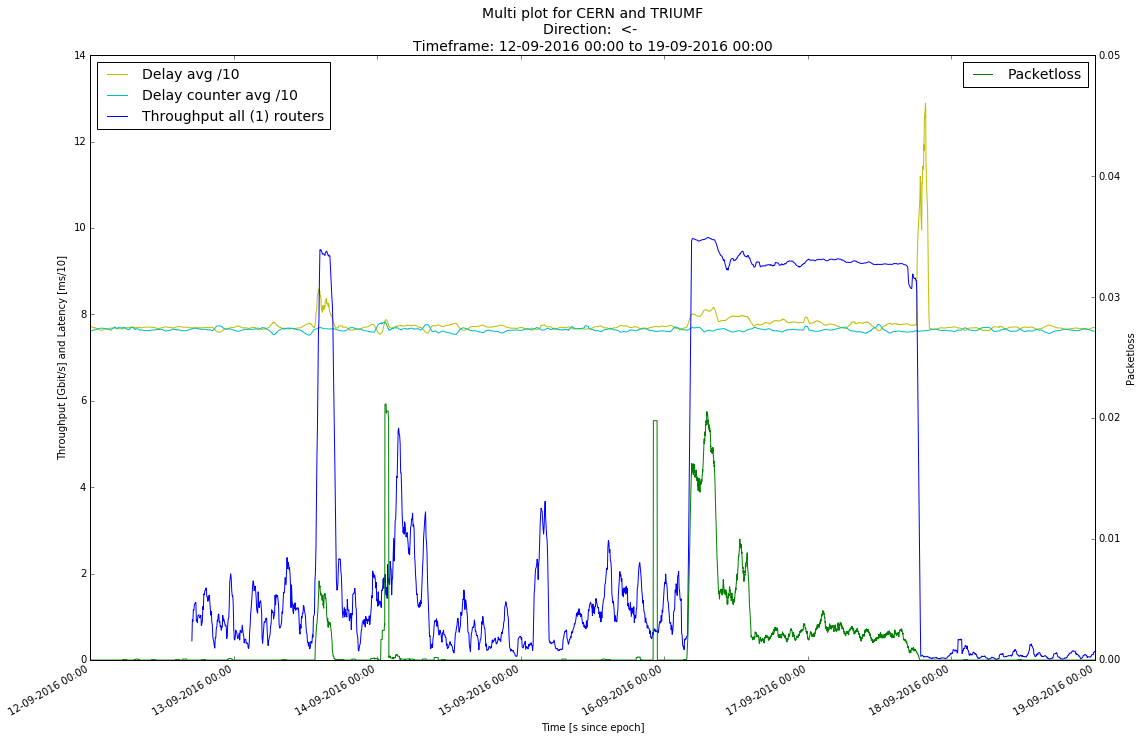

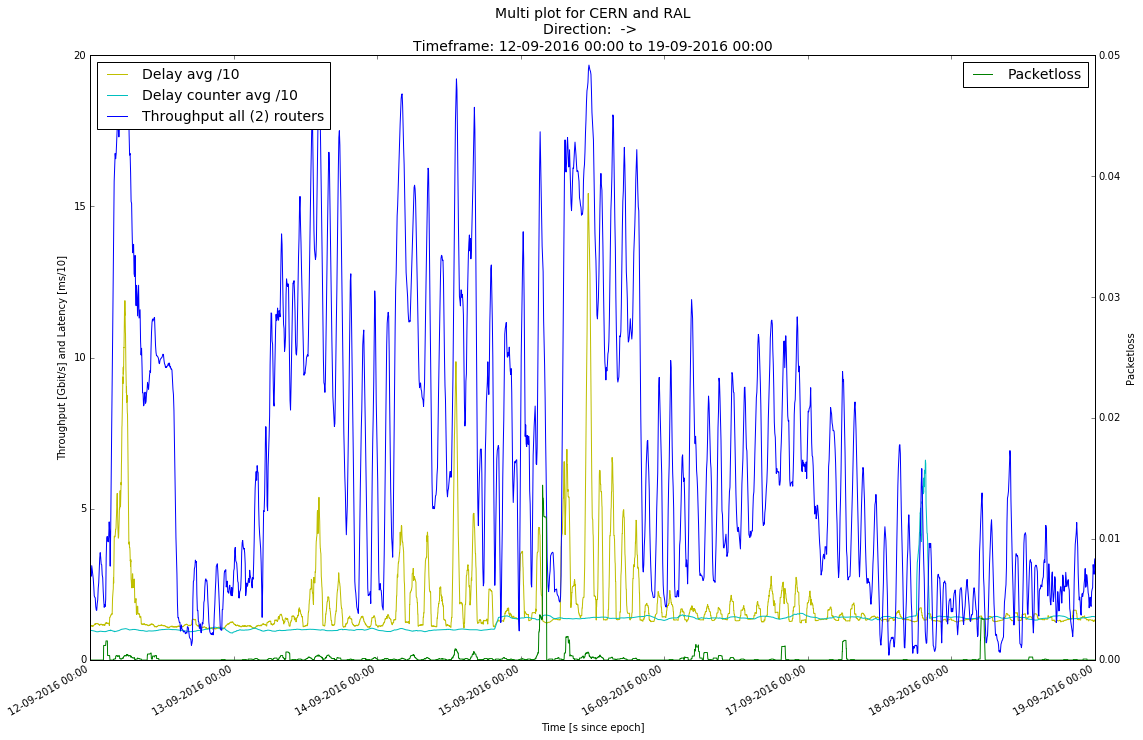

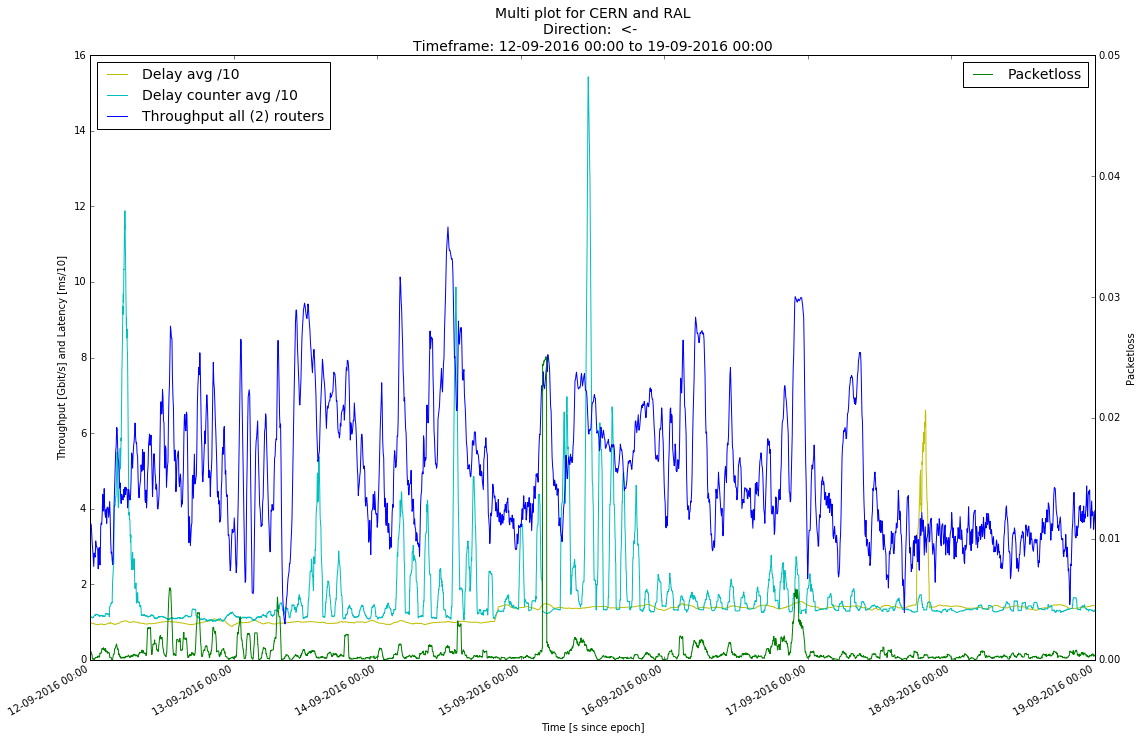

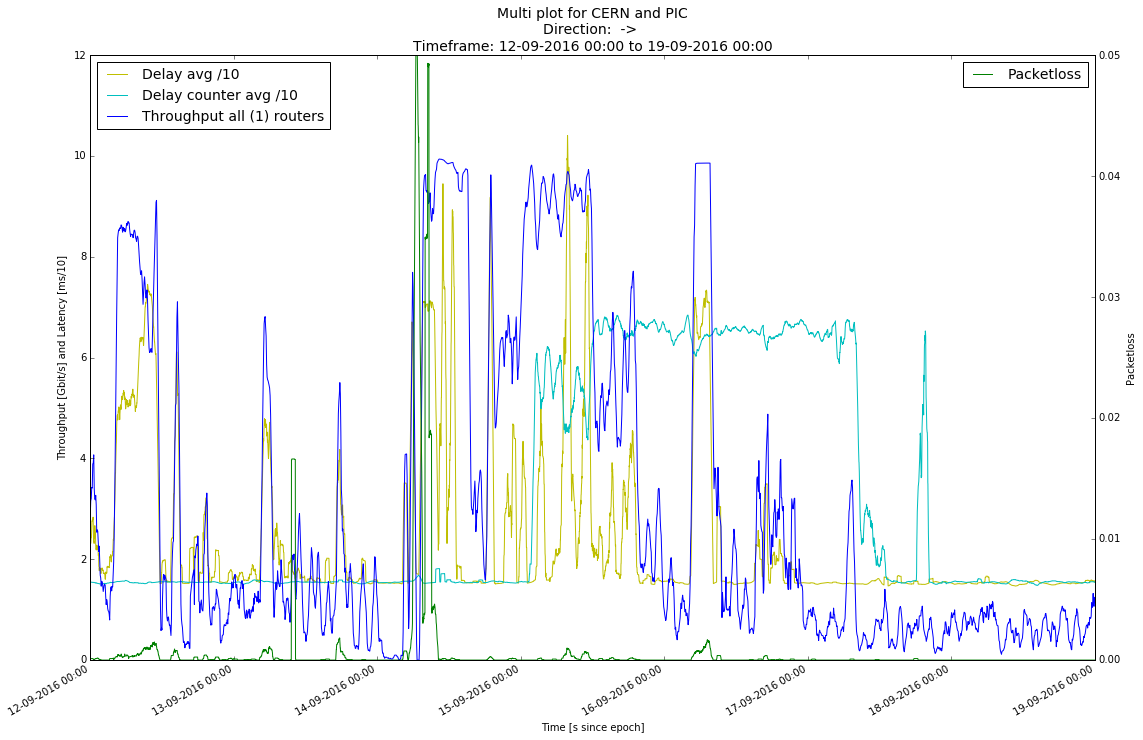

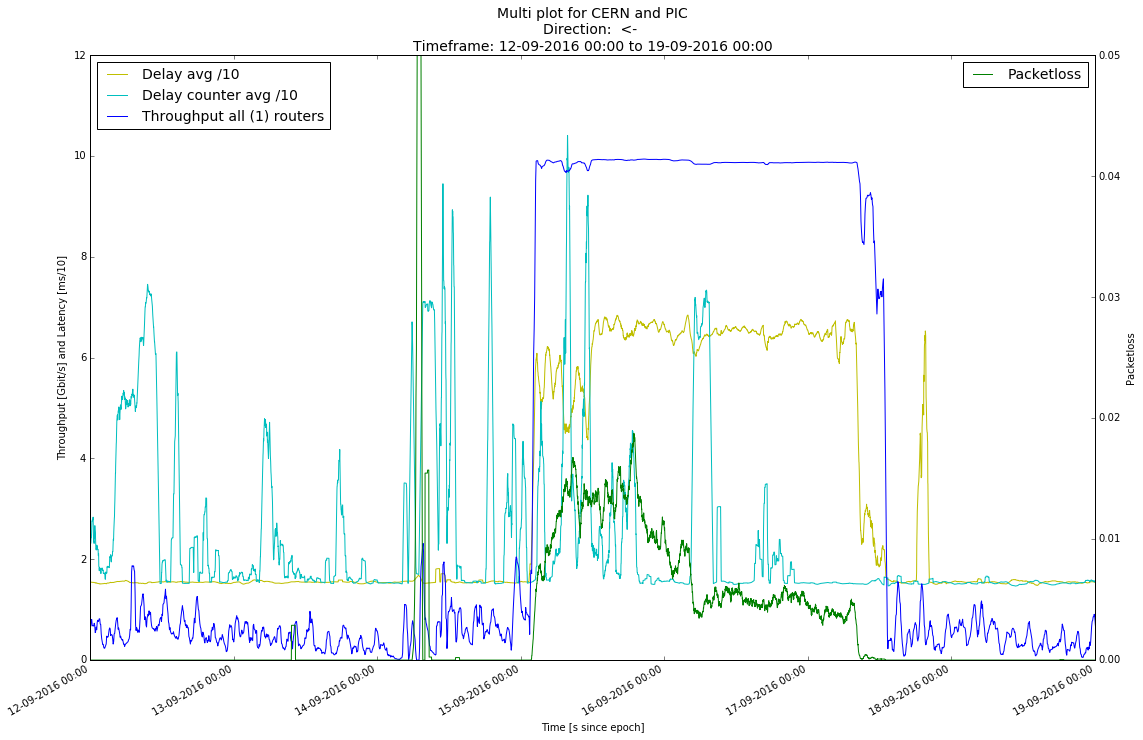

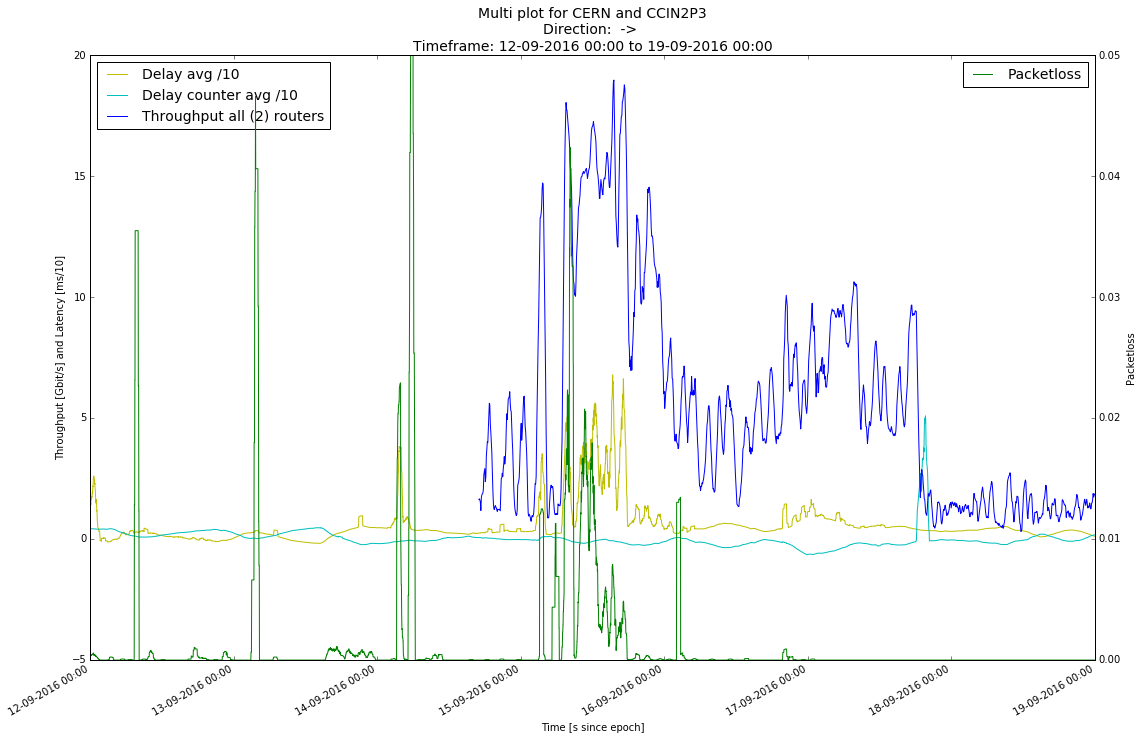

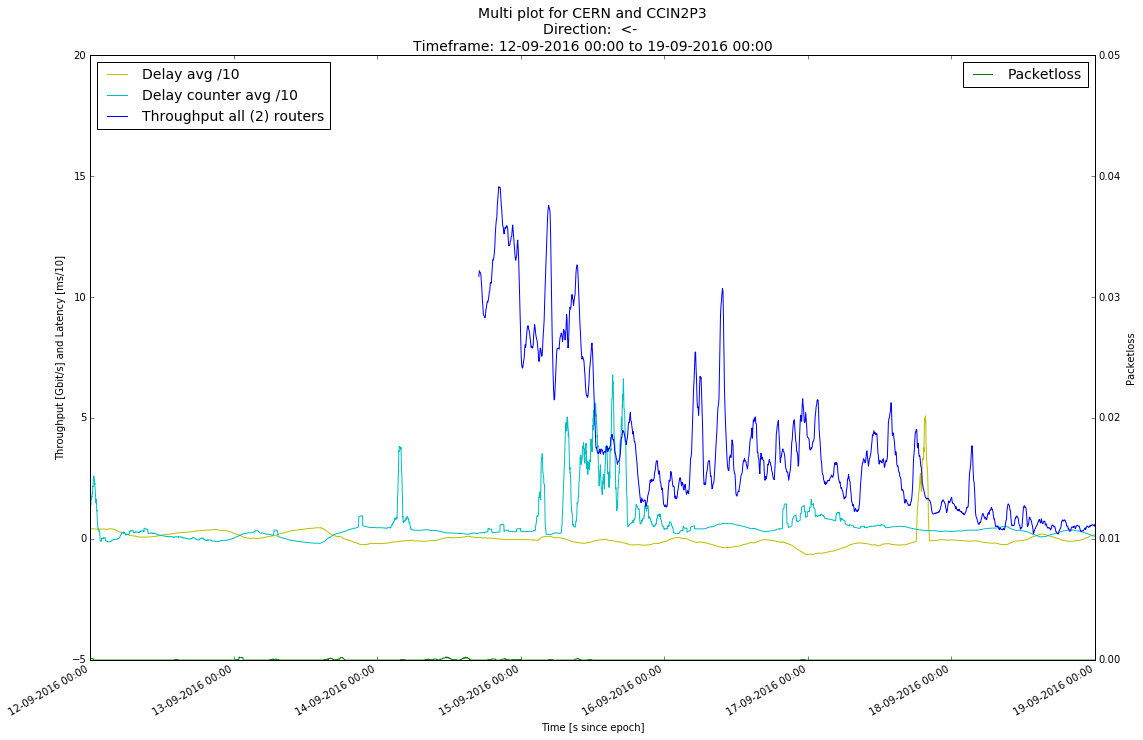

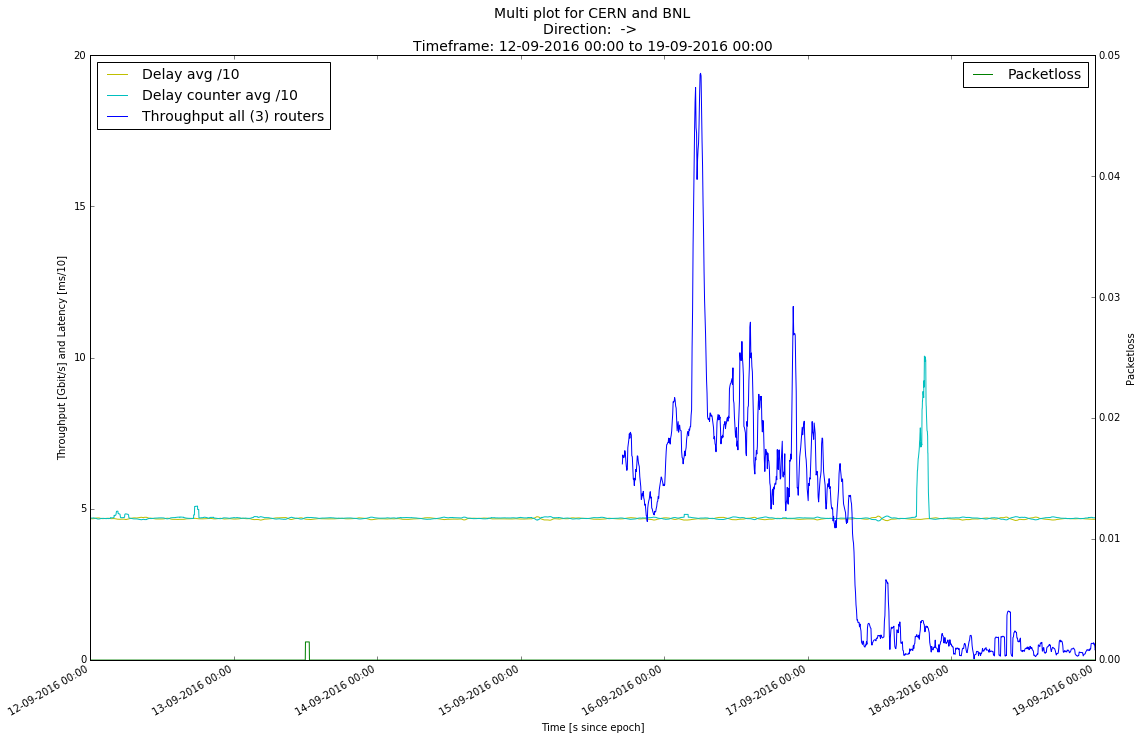

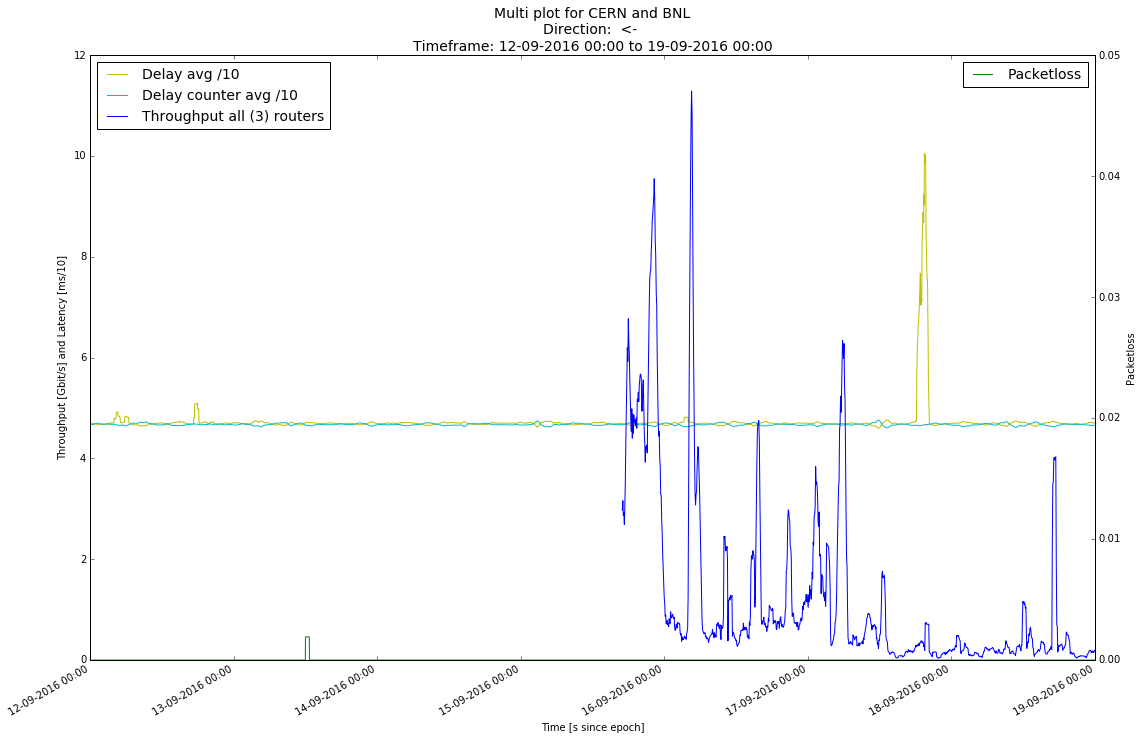

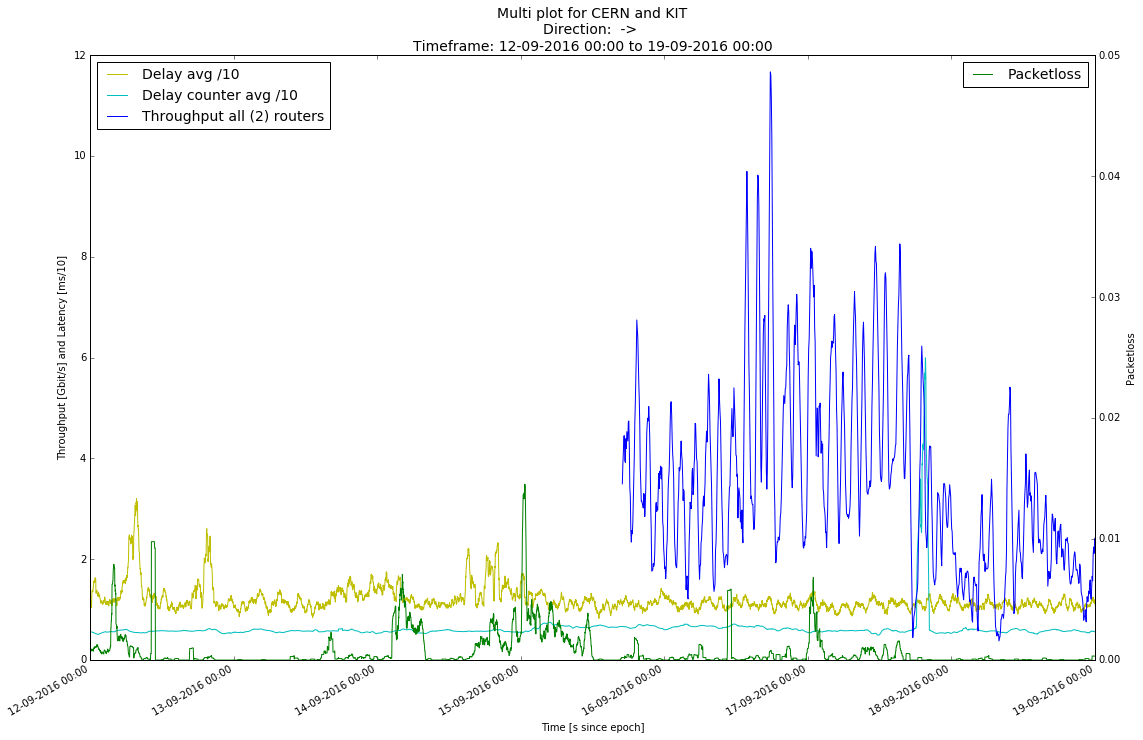

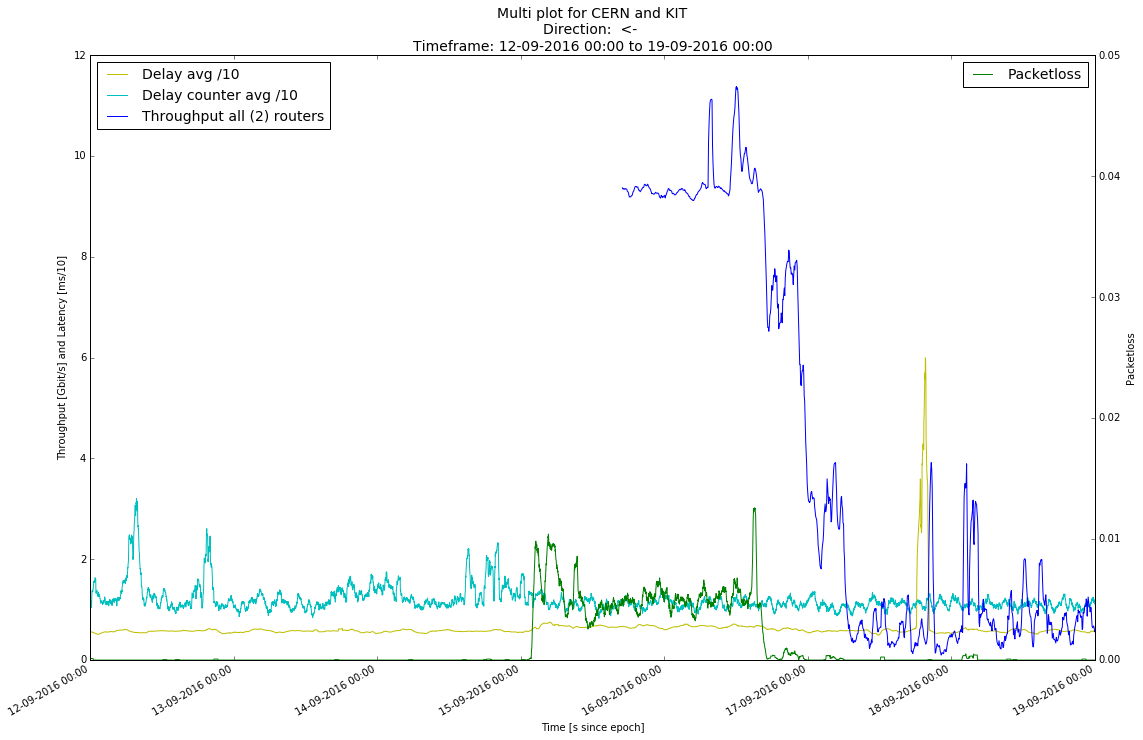

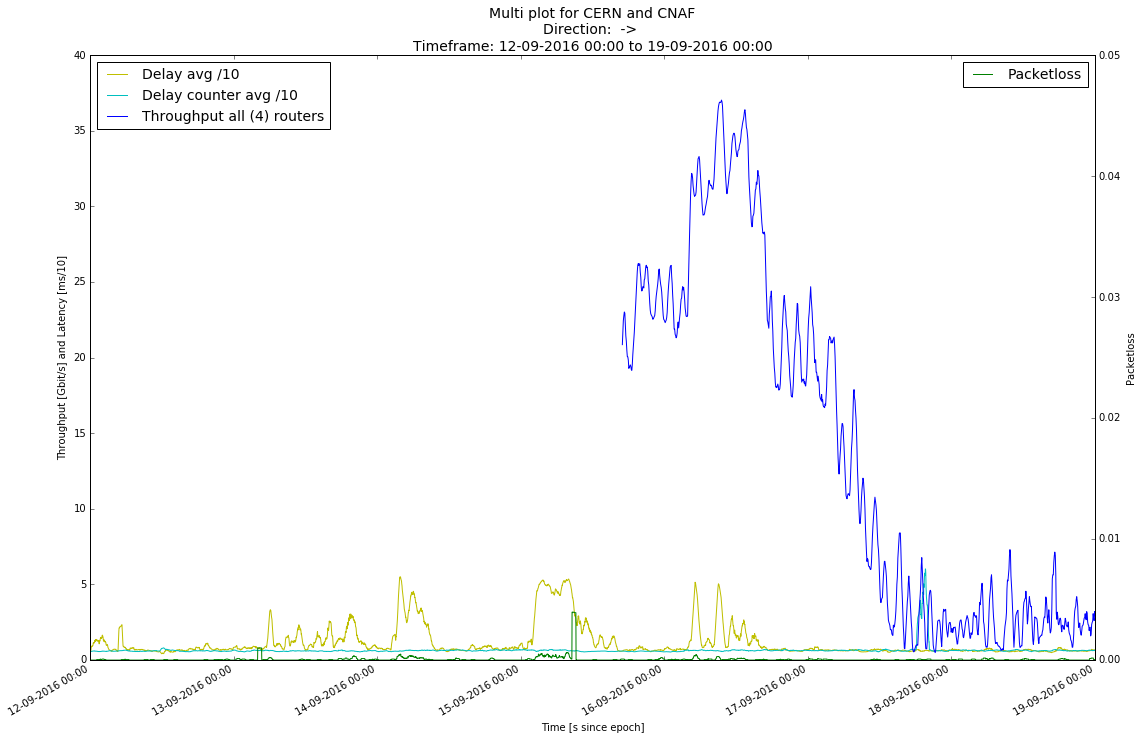

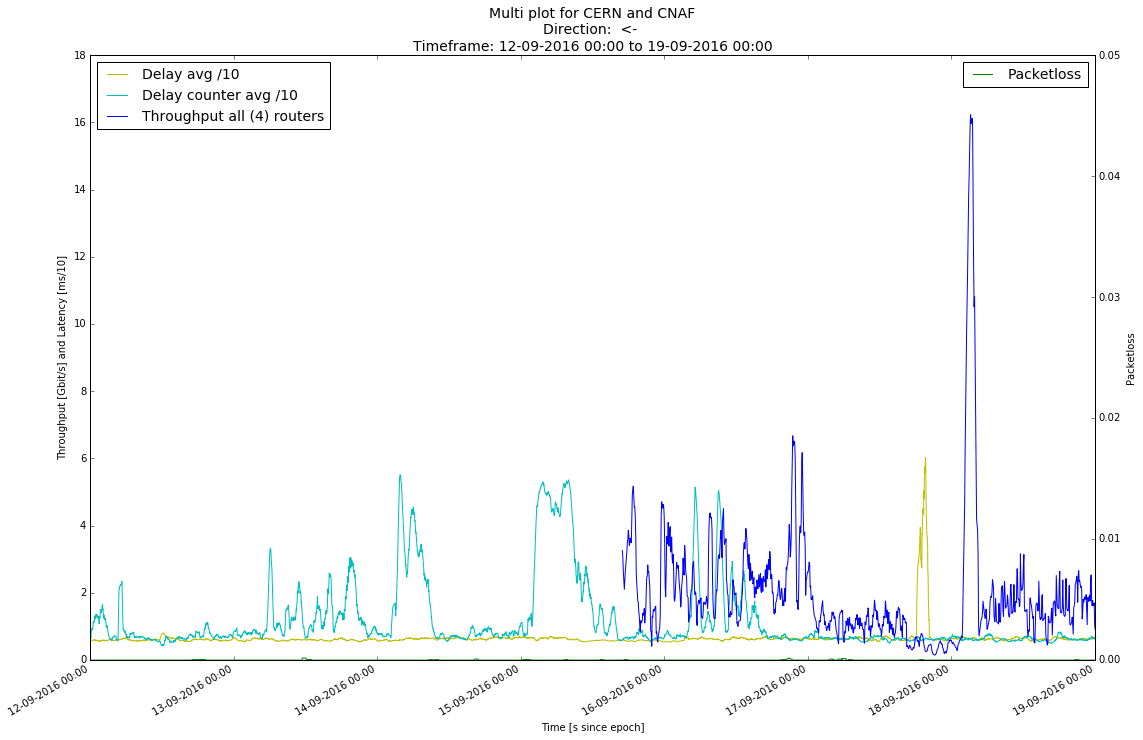

In [156]:
timeframe = ['12-09-2016 00:00', '19-09-2016 00:00']
savePath = ''
savePath = 'plots/router_multi_plots_2016-09-20/'

makeAllPlots(timeframe, savePath=savePath)

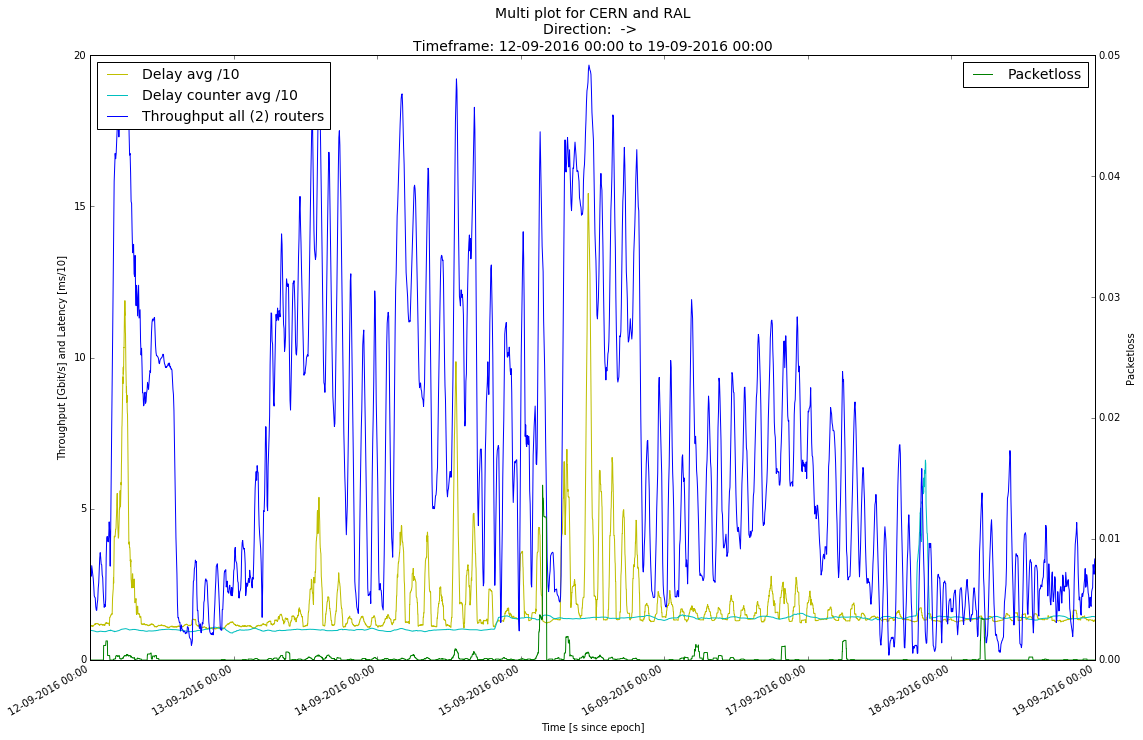

In [155]:
# configuration
src = "CERN"
dest = "RAL"
direction = "out"
timeframe = ['12-09-2016 00:00', '19-09-2016 00:00']
savePath = ''
#savePath = 'plots/router_multi_plots_2016-09-20/'

makePlot(src, dest, direction, timeframe, data_perfSonar, dates_perfSonar, data_router, dates_router, savePath=savePath)